In [126]:
import tensorflow as tf
from tensorflow.keras.layers import Activation,Flatten,Dense,Reshape,Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CosineSimilarity, MeanSquaredError
from tensorflow.keras.metrics import CosineSimilarity as CS
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sn

Reading the image dataset :-

In [2]:
test_dataset_path = "Group_3/test"
val_dataset_path = "Group_3/val"
train_dataset_path = "Group_3/train"


batch_size = 11385
data_with_aug = ImageDataGenerator(rescale=1./255)


train = data_with_aug.flow_from_directory(train_dataset_path,
                                          batch_size = batch_size,
                                          target_size=(28, 28),
                                        shuffle=None)

val = data_with_aug.flow_from_directory(val_dataset_path,
                                        batch_size = batch_size,
                                        target_size=(28, 28),shuffle=None)
                                          
test = data_with_aug.flow_from_directory(test_dataset_path,
                                         batch_size = batch_size,
                                        target_size=(28, 28),shuffle=None)
                                                                               
X_train = train[0][0]
X_val = val[0][0]
X_test = test[0][0]
print(X_test.shape)
X_val.shape

Found 11385 images belonging to 5 classes.
Found 3795 images belonging to 5 classes.
Found 3795 images belonging to 5 classes.
(3795, 28, 28, 3)


(3795, 28, 28, 3)

In [3]:
loss = []
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        loss.append(logs.get('loss'))
        if epoch > 1:
            if abs(loss[epoch -1] - loss[epoch]) < THRESHOLD:
                print("\nLoss Difference : ",loss[epoch -1] - loss[epoch])   
                self.model.stop_training = True

callbacks = myCallback()
THRESHOLD = 10e-4




In [4]:
X_train_flattened = X_train.reshape(len(X_train), 28*28*3)
X_val_flattened = X_val.reshape(len(X_val), 28*28*3)
X_test_flattened = X_test.reshape(len(X_test), 28*28*3)

In [120]:
def One_hot(n):
    y= [[1,0,0,0,0] for i in range(n)]
    y.extend([[0,1,0,0,0] for i in range(n)])
    y.extend([[0,0,1,0,0] for i in range(n)])
    y.extend([[0,0,0,1,0] for i in range(n)])
    y.extend([[0,0,0,0,1] for i in range(n)])
    y = np.array(y)
    return y
Y_train = One_hot(2277)
Y_val = One_hot(759)
Y_test=One_hot(759)

In [5]:
def comparison_plot(img1, img2,index,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(20,50))
    plt.subplot(1,2,1)
    plt.title(f"Reconstructed{index}")
    plt.imshow(img1, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title(f"Original{index}")
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    return 0


 autoencoders with one hidden layer :-

Epoch 1/200
356/356 [==============================] - 10s 27ms/step - loss: 0.0429 - cosine_similarity: 0.7953 - val_loss: 0.0243 - val_cosine_similarity: 0.8905
Epoch 2/200
356/356 [==============================] - 10s 28ms/step - loss: 0.0180 - cosine_similarity: 0.9184 - val_loss: 0.0137 - val_cosine_similarity: 0.9389
Epoch 3/200
356/356 [==============================] - 10s 29ms/step - loss: 0.0111 - cosine_similarity: 0.9494 - val_loss: 0.0094 - val_cosine_similarity: 0.9567
Epoch 4/200
356/356 [==============================] - 10s 27ms/step - loss: 0.0079 - cosine_similarity: 0.9637 - val_loss: 0.0072 - val_cosine_similarity: 0.9673
Epoch 5/200
356/356 [==============================] - 10s 28ms/step - loss: 0.0062 - cosine_similarity: 0.9717 - val_loss: 0.0059 - val_cosine_similarity: 0.9735
Epoch 6/200
356/356 [==============================] - 10s 27ms/step - loss: 0.0051 - cosine_similarity: 0.9767 - val_loss: 0.0050 - val_cosine_similarity: 0.9767
Epoch 7/200
356/356 [=

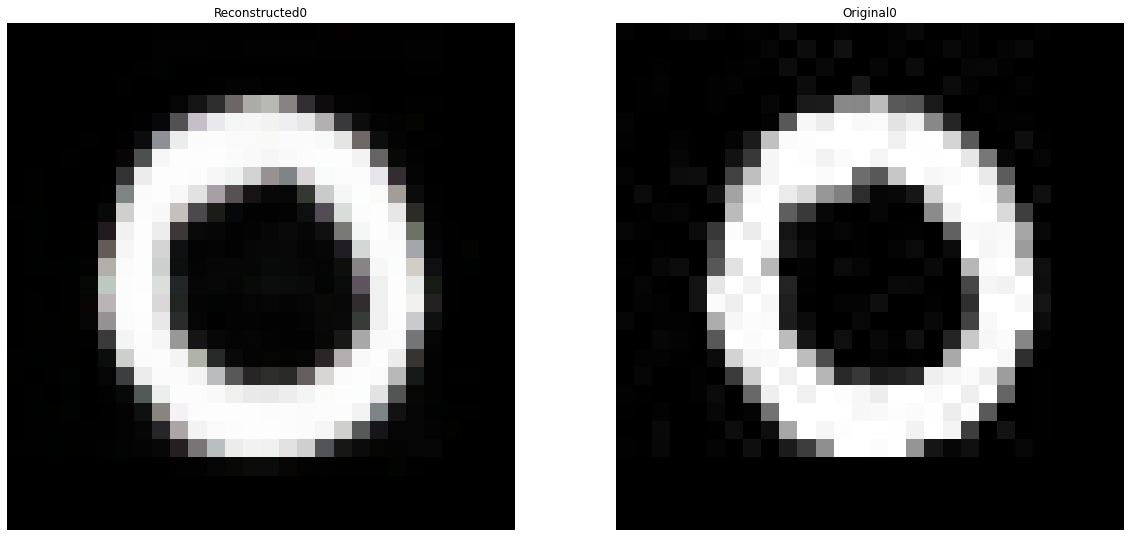

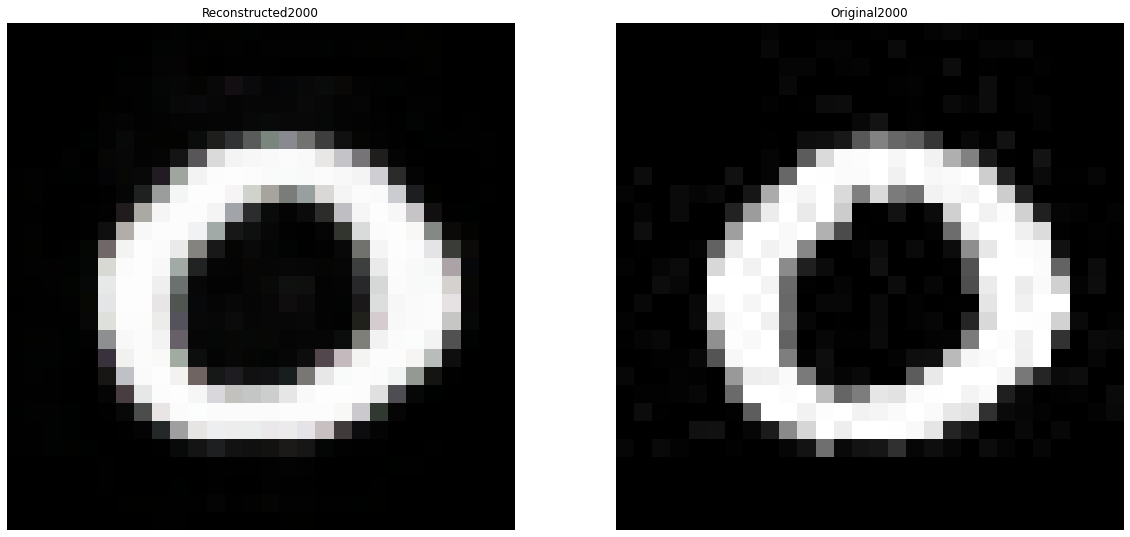

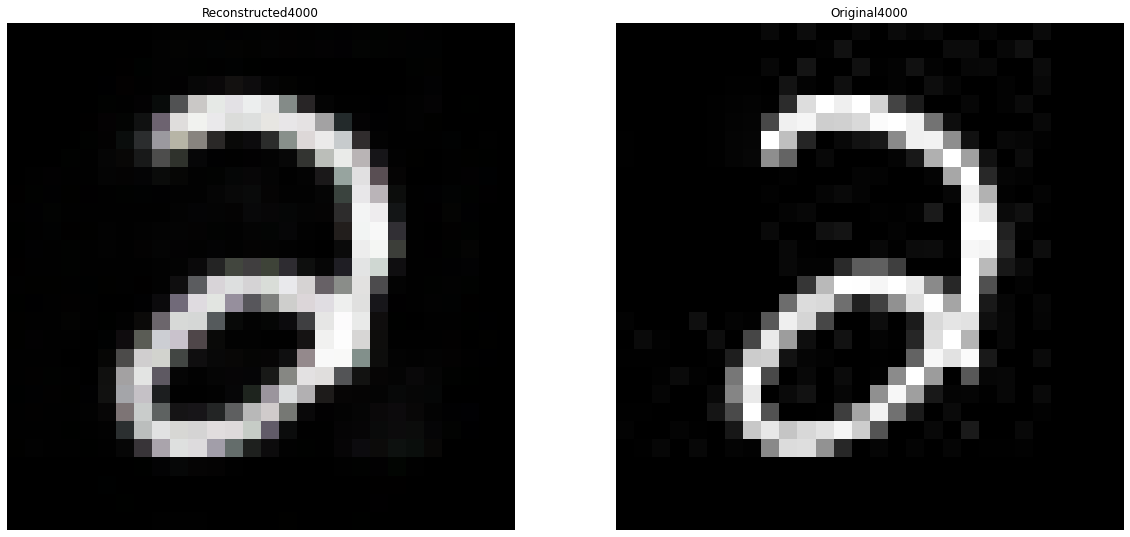

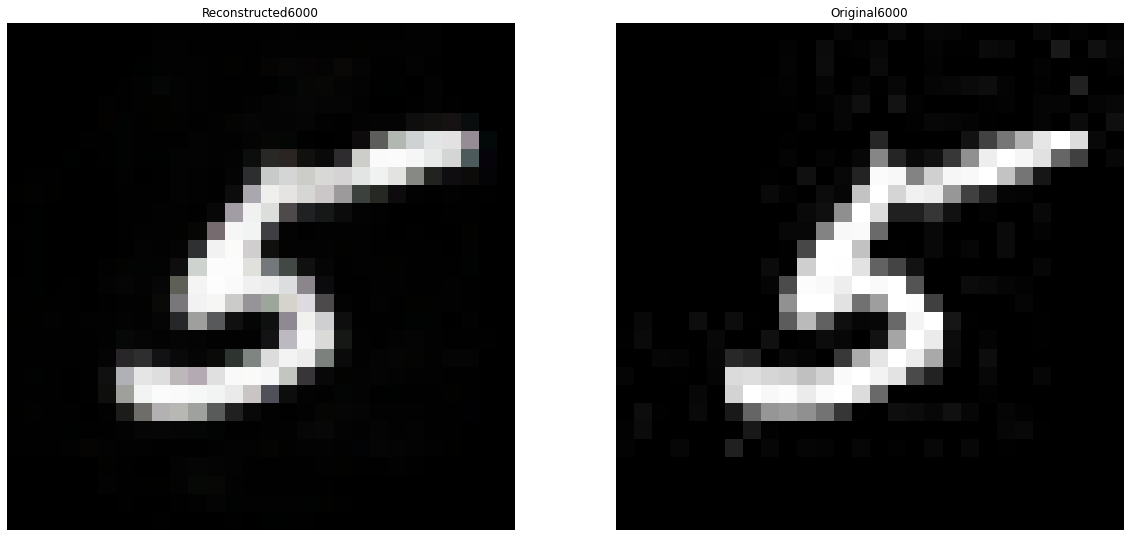

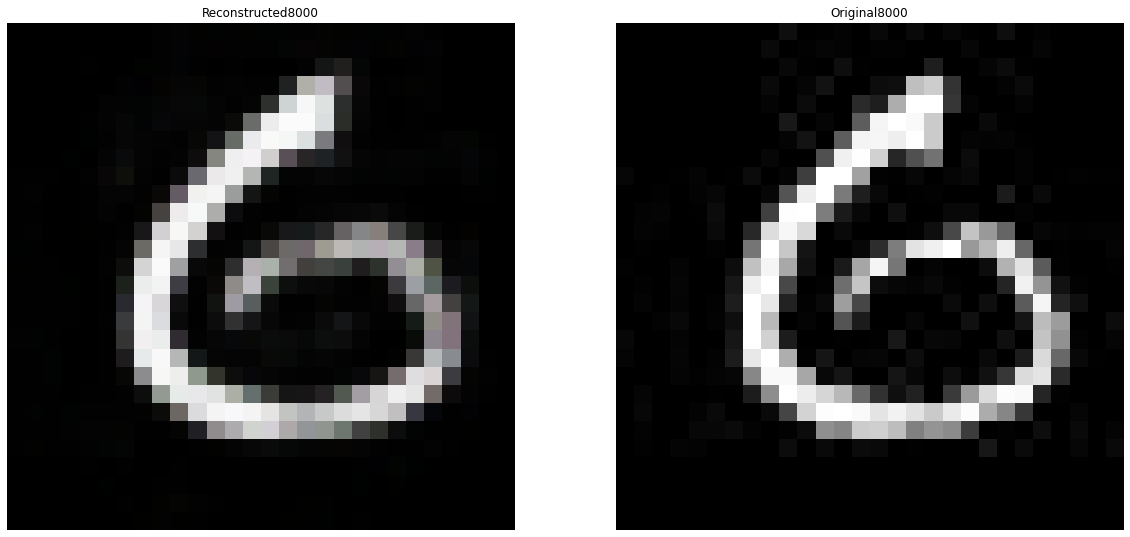

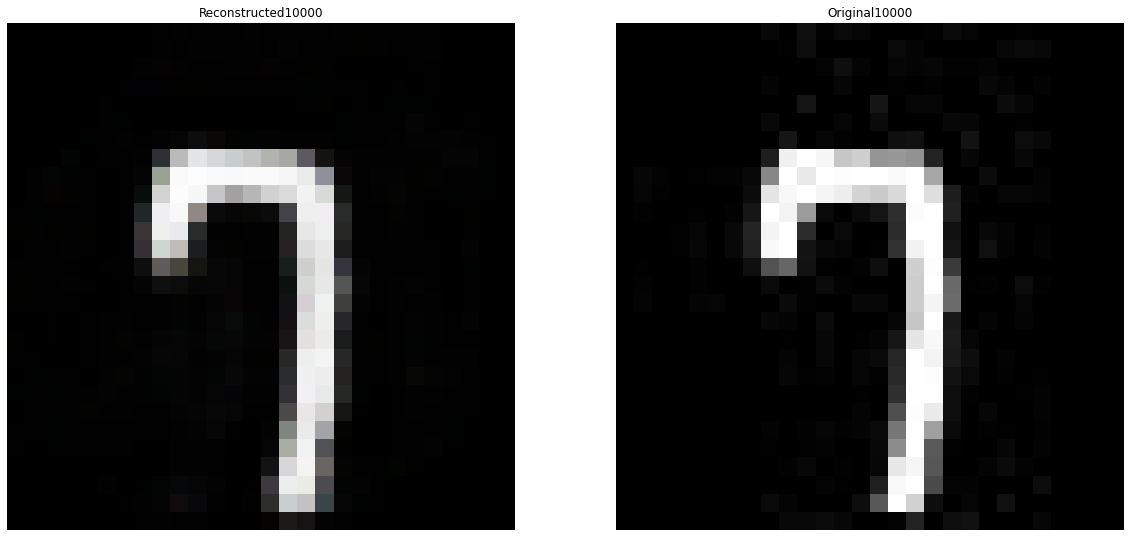

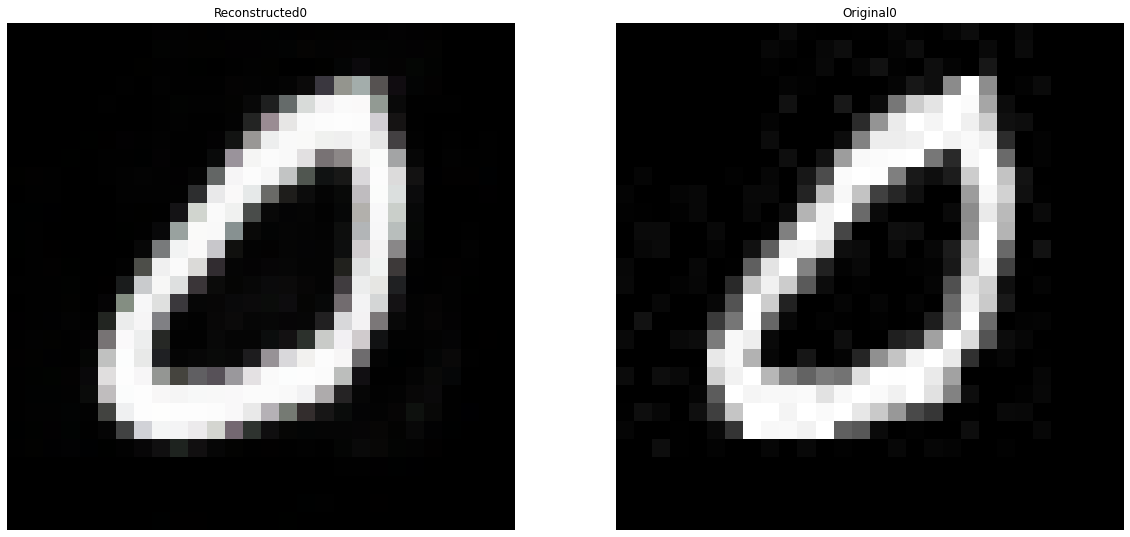

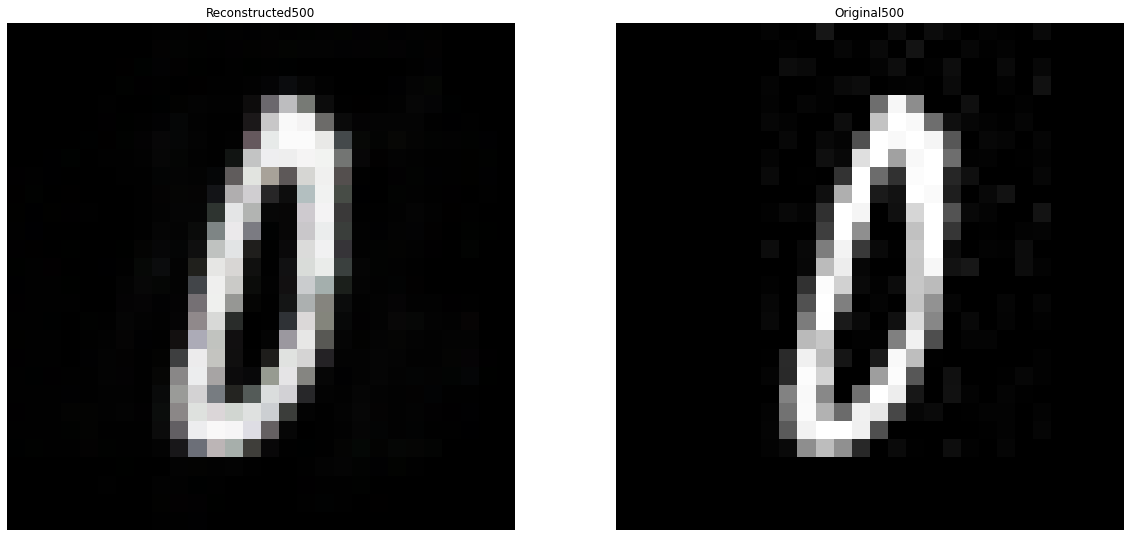

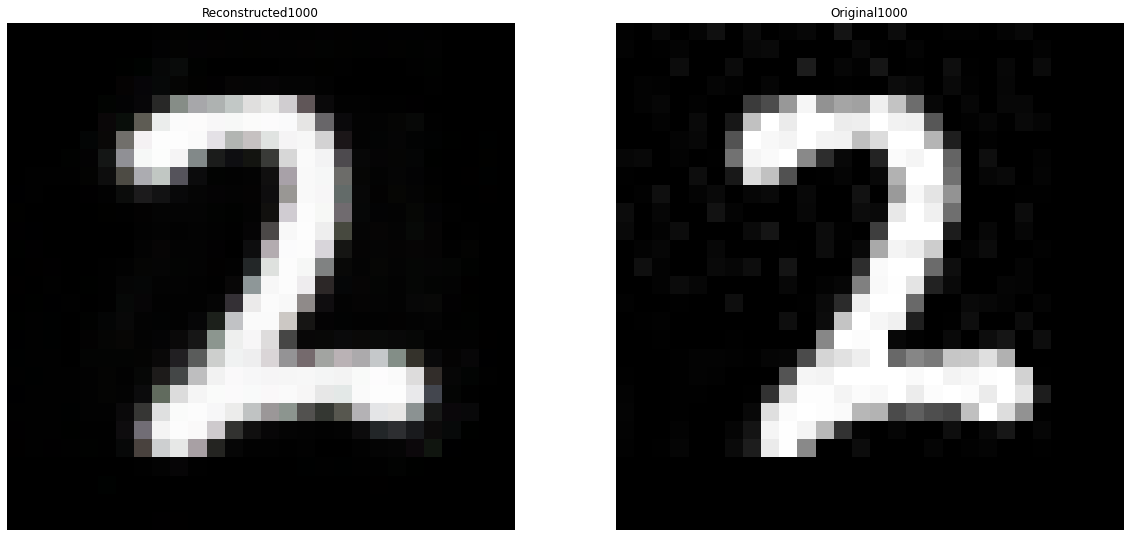

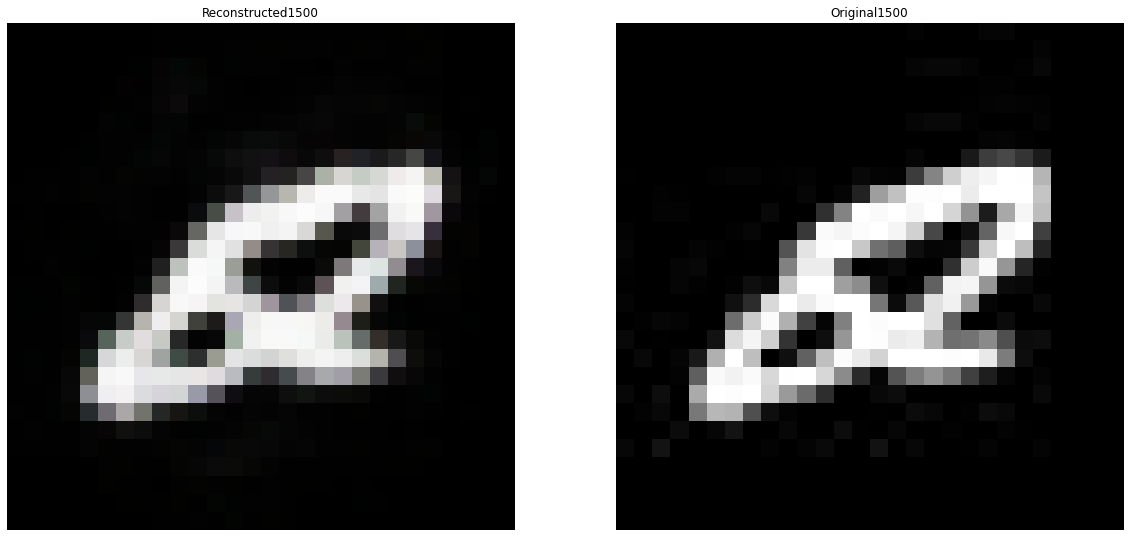

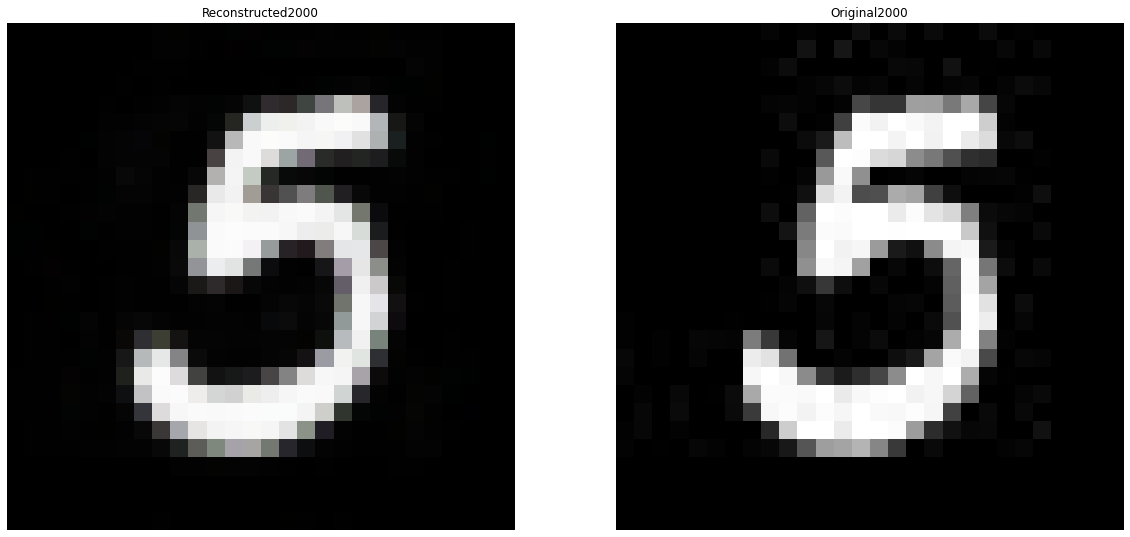

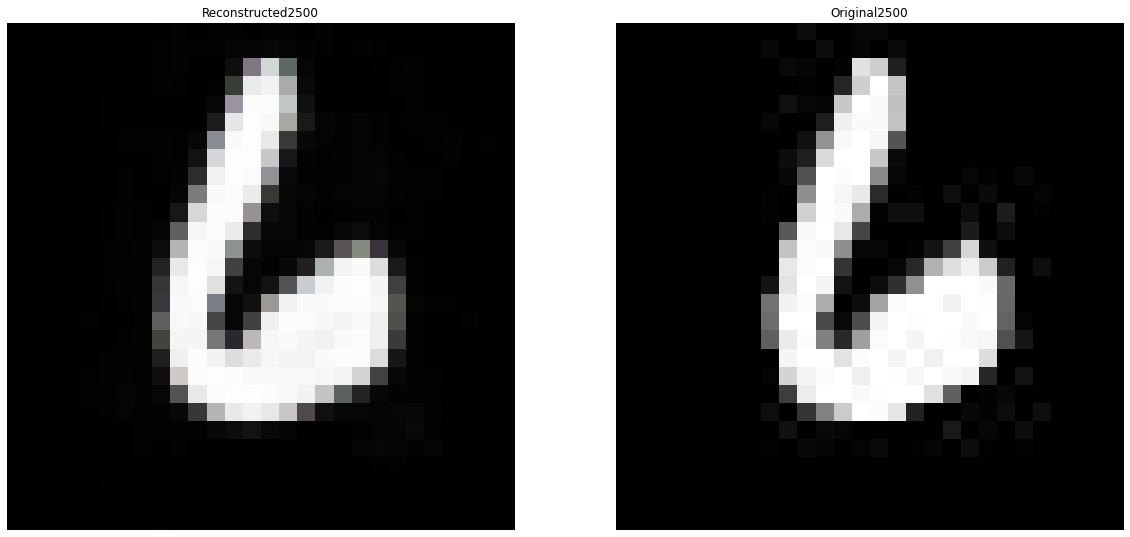

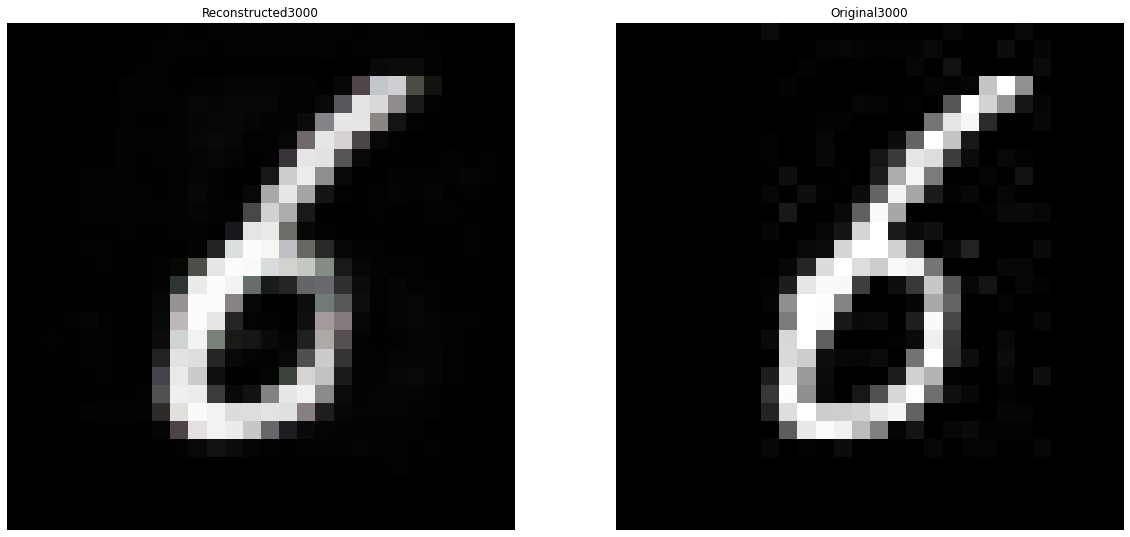

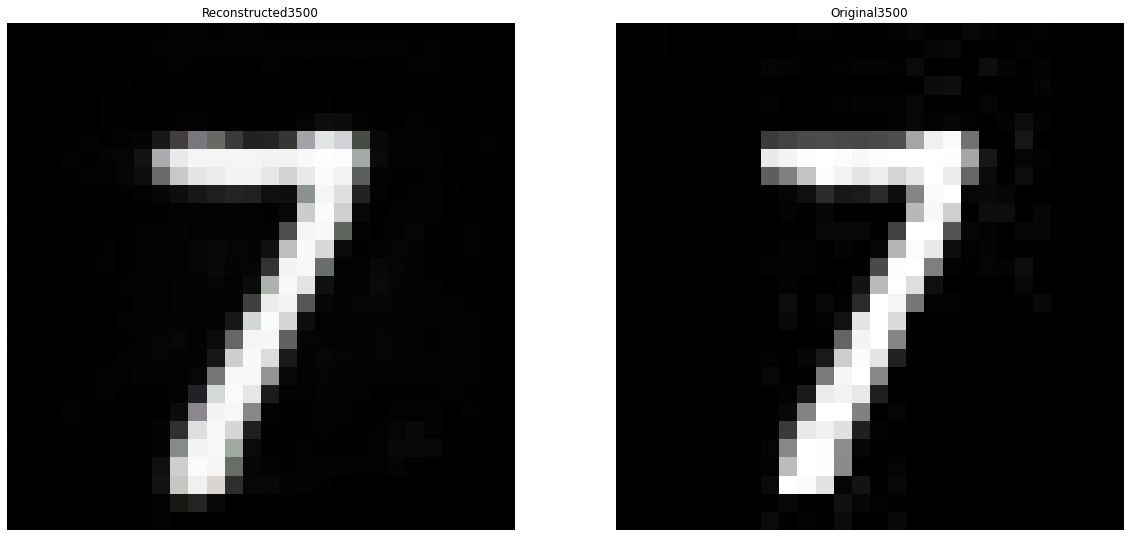

In [72]:
autoencoder = Sequential([
    Dense(512, activation = 'sigmoid', input_shape = (28*28*3,)),
    Dense(28*28*3, activation = 'sigmoid'),
    ])

opt = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt,
              loss = MeanSquaredError(), #because images are of large size, they may be far apart in traditional MSE.
              metrics = CS())

history = autoencoder.fit(
    X_train_flattened, X_train_flattened,validation_data=(X_val_flattened,X_val_flattened),
    shuffle = True,
    epochs = 200,callbacks = [callbacks])


what = autoencoder.predict(X_train_flattened)
    
for i in range(0,11000,2000):

    this = what[i].reshape((28,28,3))
    #print(this.shape)
    comparison_plot(this, X_train_flattened[i].reshape((28,28,3)), index = i)


what = autoencoder.predict(X_val_flattened)
for i in range(0,3795,500):

    this = what[i].reshape((28,28,3))
    
    comparison_plot(this, X_val_flattened[i].reshape((28,28,3)), index = i)


In [73]:
autoencoder.evaluate(X_test_flattened,X_test_flattened )

119/119 [==============================] - 1s 8ms/step - loss: 0.0034 - cosine_similarity: 0.9842


[0.0034250079188495874, 0.9842142462730408]

dict_keys(['loss', 'cosine_similarity', 'val_loss', 'val_cosine_similarity'])


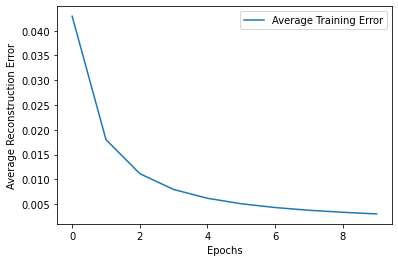

In [74]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Average Reconstruction Error")
plt.legend(['Average Training Error'], loc='upper right')


Weight Visualization :-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

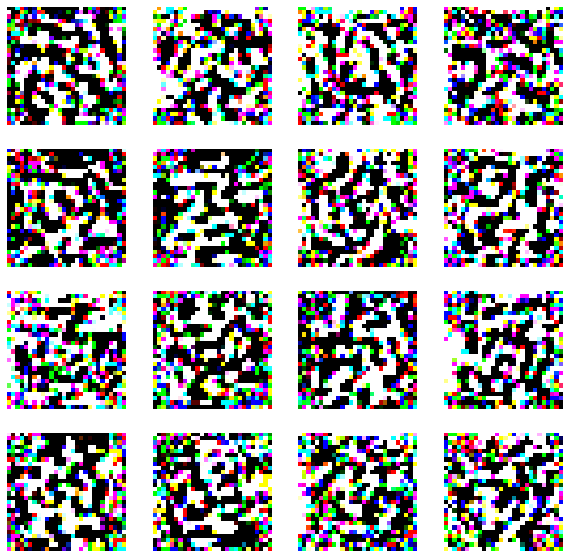

In [94]:
fig = plt.figure(figsize=(10,10))  
maximal_weights =  np.array(autoencoder.weights[0])
for i in range(512):
    maximal_weights[:,i] = (maximal_weights[:,i]*255)/np.linalg.norm(maximal_weights[:,i])
for i in range(1,17):
    fig.add_subplot(4, 4, i)
    plt.imshow(maximal_weights[:,i-1].reshape(28,28,3),cmap='gray')
    plt.axis('off')


Classification using the compressed representation from the encoder with one 
hidden layer

Epoch 1/40
356/356 [==============================] - 4s 9ms/step - loss: 0.1818 - accuracy: 0.9426 - val_loss: 0.1144 - val_accuracy: 0.9628
Epoch 2/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0993 - accuracy: 0.9687 - val_loss: 0.0875 - val_accuracy: 0.9713
Epoch 3/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0659 - accuracy: 0.9794 - val_loss: 0.0731 - val_accuracy: 0.9763
Epoch 4/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0427 - accuracy: 0.9874 - val_loss: 0.0661 - val_accuracy: 0.9776
Epoch 5/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0274 - accuracy: 0.9924 - val_loss: 0.0628 - val_accuracy: 0.9794
Epoch 6/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0712 - val_accuracy: 0.9797
Epoch 7/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0126 - accuracy: 0.9974 - val_loss: 0.0576 - val_accuracy: 0.9816
Epoch 

0

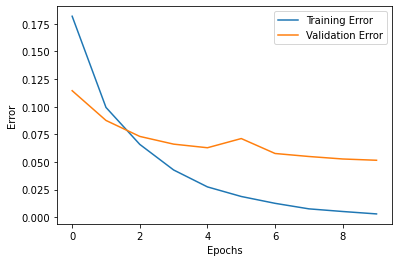

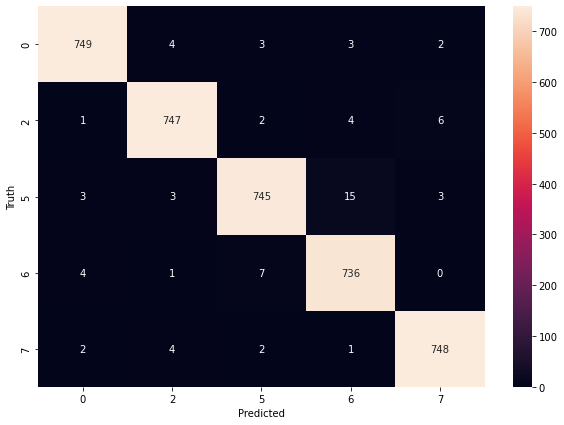

In [129]:
def oneLayer(n1,X_train_flattened = X_train_flattened): #n1 is the the encoding number of neurons for 1-layer-autoencoder

    autoencoder = Sequential([
        Dense(n1, activation = 'sigmoid', input_shape = (28*28*3,)),
        Dense(5, activation = 'sigmoid')])
    
    opt = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt,
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    history = autoencoder.fit(
        X_train_flattened, Y_train,
        shuffle = True,
        epochs = 40,
        verbose = 1,callbacks = [callbacks],validation_data=(X_val_flattened,Y_val))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(['Training Error','Validation Error'], loc='upper right')
    
    what = autoencoder.predict(X_test_flattened)
    y_pred = []
    for i in range(len(what)):
        c = np.argmax(what[i])
        y_pred.append(c)
    
    
    cm = confusion_matrix(y_pred,test.classes)
    categories = ['0', '2','5','6','7']
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt='d',xticklabels=categories,yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print('Accuracy: %.3f' % accuracy_score(test.classes,y_pred))

    
    return 0
oneLayer(512,X_train_flattened)

autoencoders with 3 hidden layer architectures

In [116]:
def threeLayer(n1, n2,n3): #n1 and n2 are the encoding number of neurons for 3-layer-autoencoder

    autoencoder = Sequential([
        Dense(n1, activation = 'sigmoid', input_shape = (28*28*3,)),
        Dense(n2, activation = 'sigmoid'),
        Dense(n3, activation = 'sigmoid'),
        Dense(28*28*3, activation = 'sigmoid')])
    
    opt = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt,
                  loss = MeanSquaredError(), #because images are of large size, they may be far apart in traditional MSE.
              metrics = CS())
    autoencoder.summary
    history = autoencoder.fit(
        X_train_flattened, X_train_flattened,validation_data=(X_val_flattened,X_val_flattened),
        shuffle = True,
        epochs = 25, #after this loss starts oscillating
        verbose = 1,callbacks = [callbacks]
    )
    what = autoencoder.predict(X_train_flattened)
    
    for i in range(0,11000,2000):

        this = what[i].reshape((28,28,3))
        print(this.shape)
        comparison_plot(this, X_train_flattened[i].reshape((28,28,3)), index = i)


    what = autoencoder.predict(X_val_flattened)
    for i in range(0,3795,500):

        this = what[i].reshape((28,28,3))

        comparison_plot(this, X_val_flattened[i].reshape((28,28,3)), index = i)
    
    autoencoder.evaluate(X_test_flattened,X_test_flattened)
    
    
    
    fig = plt.figure(figsize=(10,10))  
    maximal_weights =  np.array(autoencoder.weights[0])
    for i in range(128):
        maximal_weights[:,i] = (maximal_weights[:,i]*255)/np.linalg.norm(maximal_weights[:,i])
    for i in range(1,17):
        fig.add_subplot(4, 4, i)
        plt.imshow(maximal_weights[:,i-1].reshape(28,28,3),cmap='gray')
        plt.axis('off')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Average Reconstruction Error")
    plt.legend(['Average Training Error'], loc='upper right')
    plt.show()

    return 0

Epoch 1/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0645 - cosine_similarity: 0.6772 - val_loss: 0.0526 - val_cosine_similarity: 0.7429
Epoch 2/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0452 - cosine_similarity: 0.7782 - val_loss: 0.0388 - val_cosine_similarity: 0.8146
Epoch 3/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0347 - cosine_similarity: 0.8324 - val_loss: 0.0320 - val_cosine_similarity: 0.8467
Epoch 4/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0296 - cosine_similarity: 0.8562 - val_loss: 0.0275 - val_cosine_similarity: 0.8671
Epoch 5/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0257 - cosine_similarity: 0.8745 - val_loss: 0.0243 - val_cosine_similarity: 0.8827
Epoch 6/25
356/356 [==============================] - 6s 16ms/step - loss: 0.0229 - cosine_similarity: 0.8890 - val_loss: 0.0218 - val_cosine_similarity: 0.8949
Epoch 7/25
356/356 [==============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

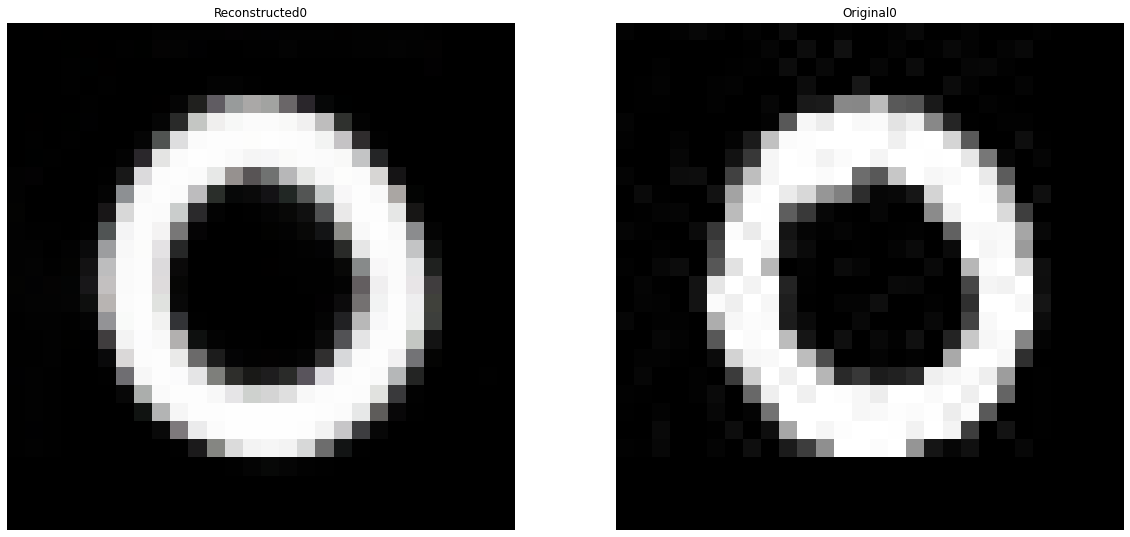

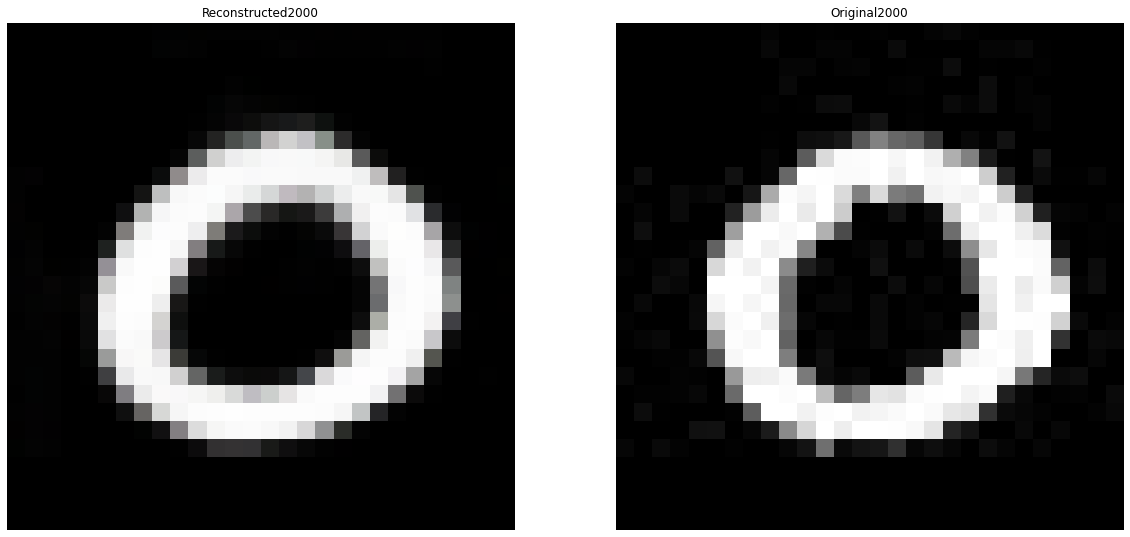

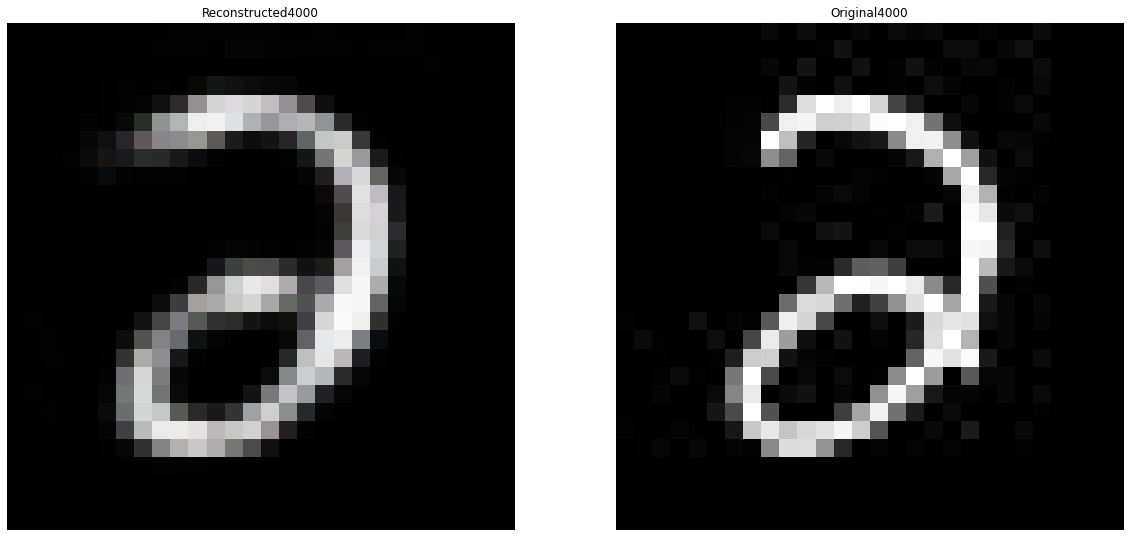

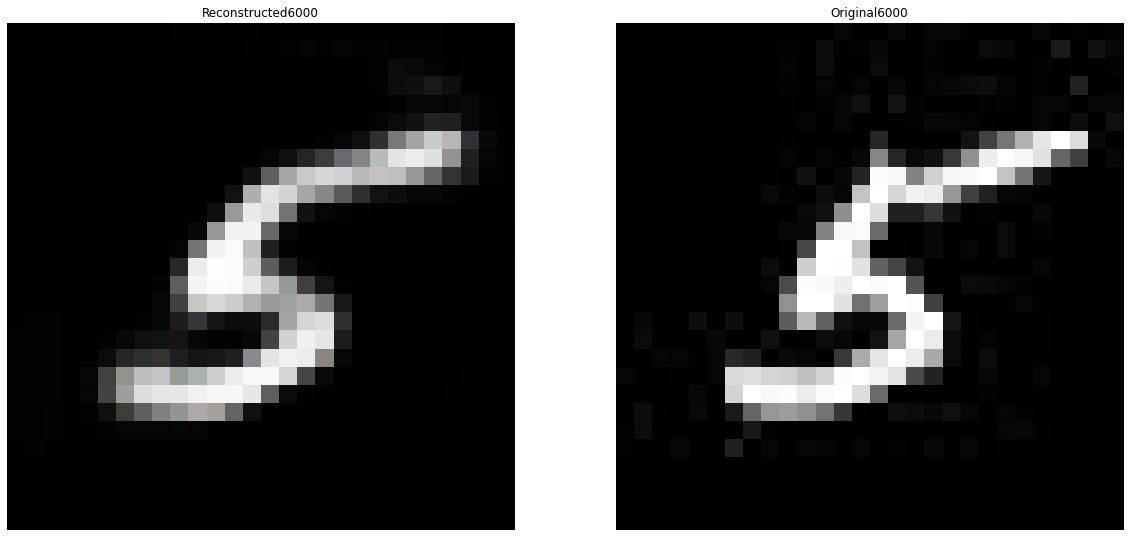

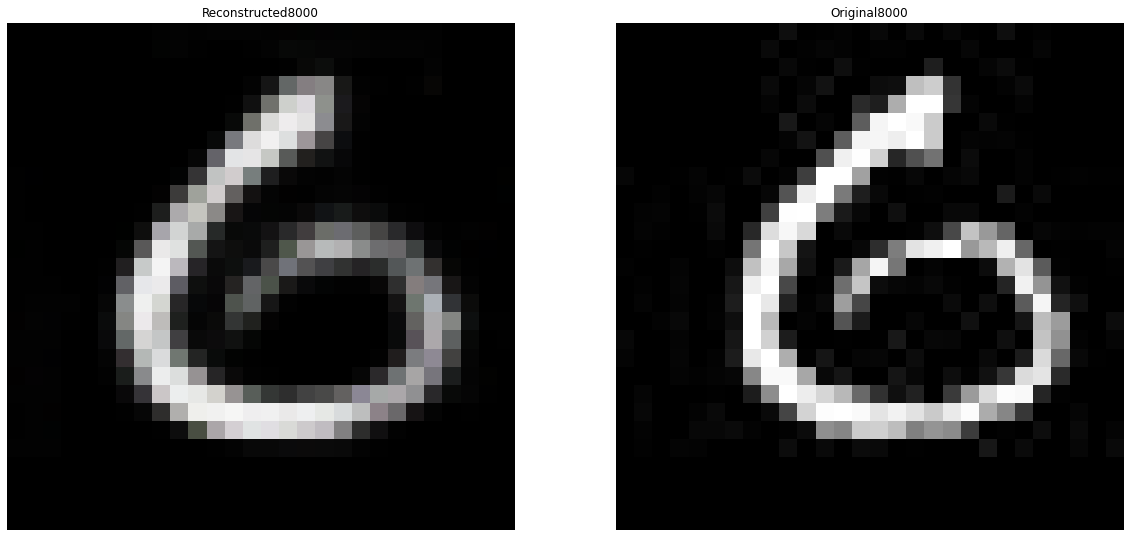

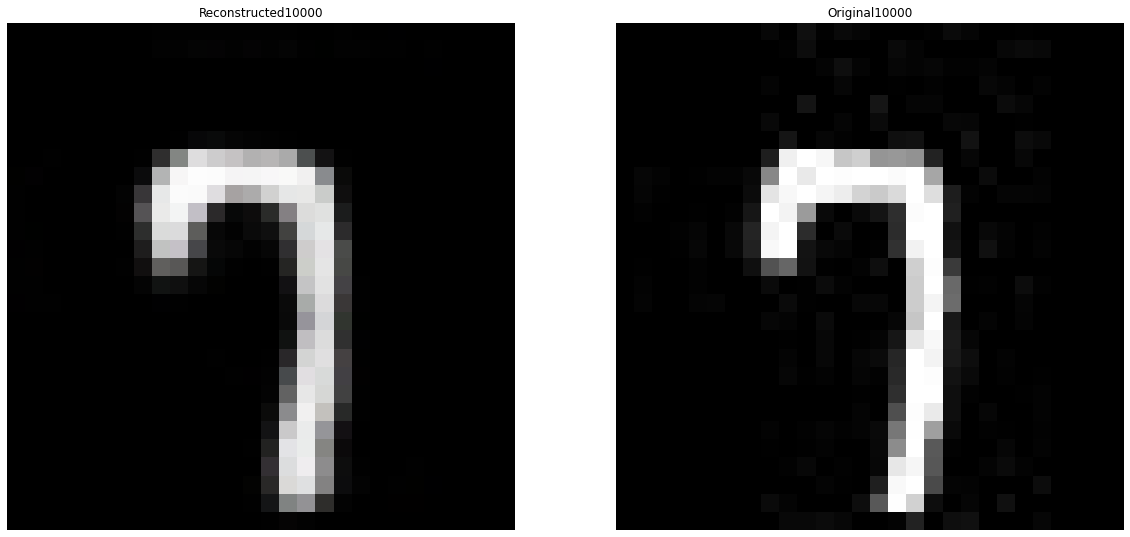

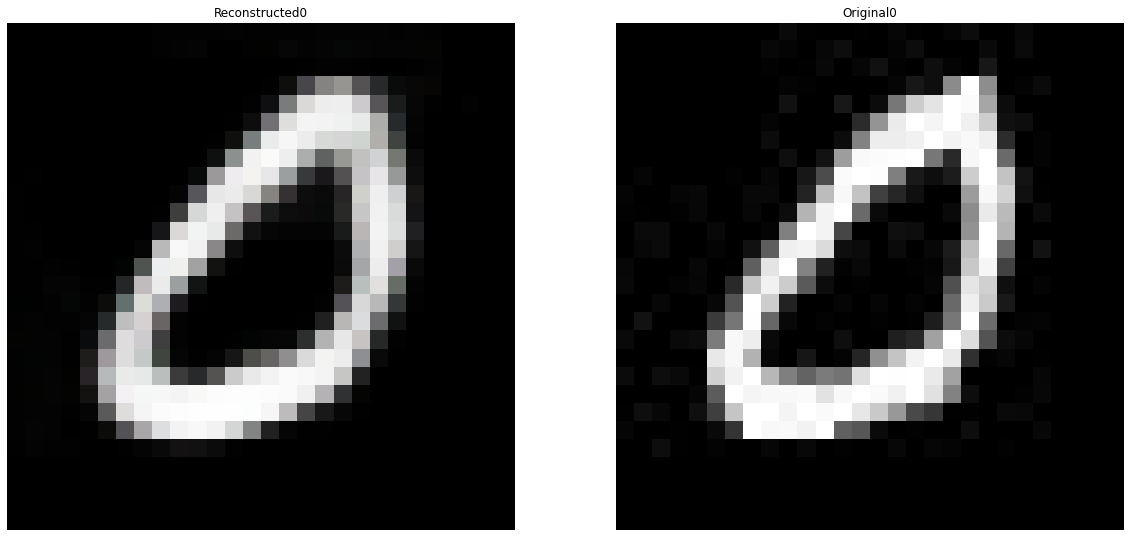

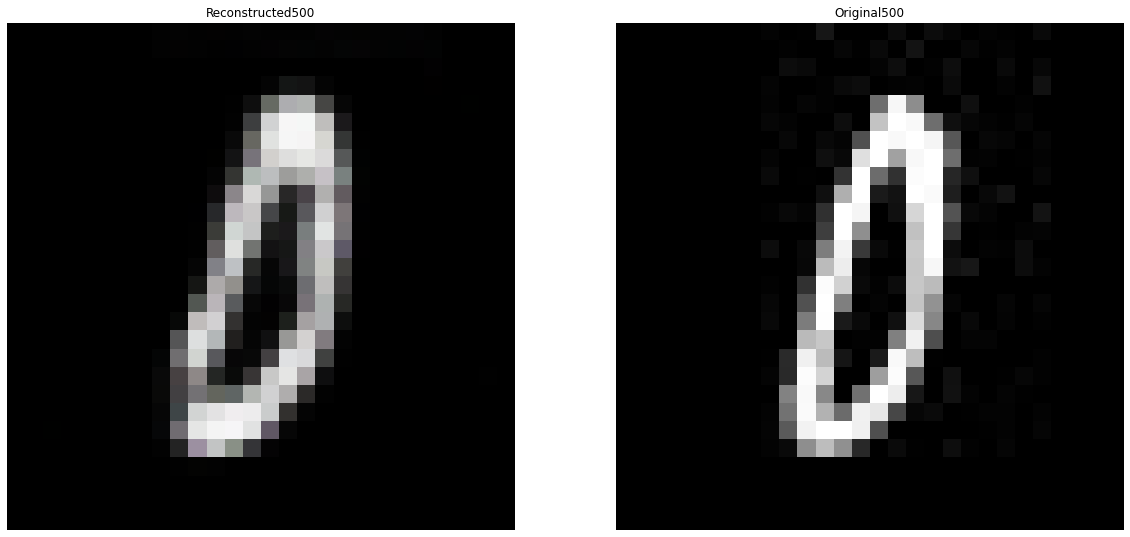

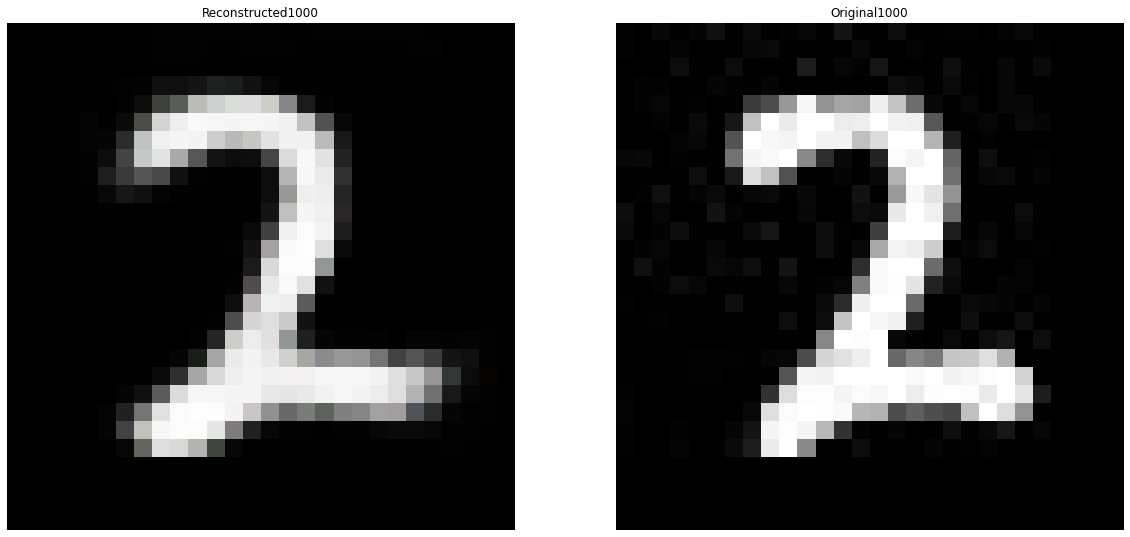

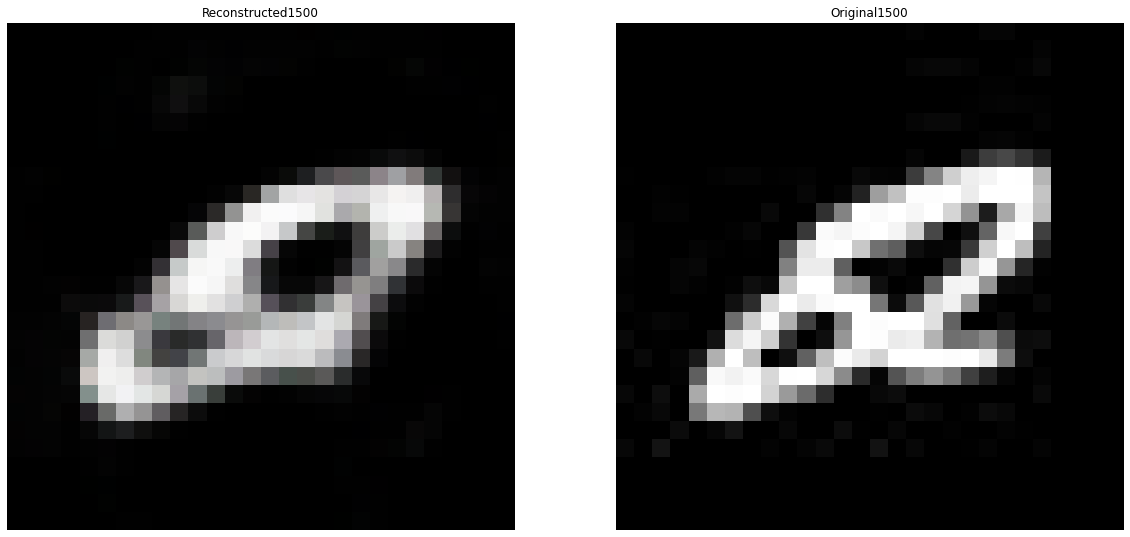

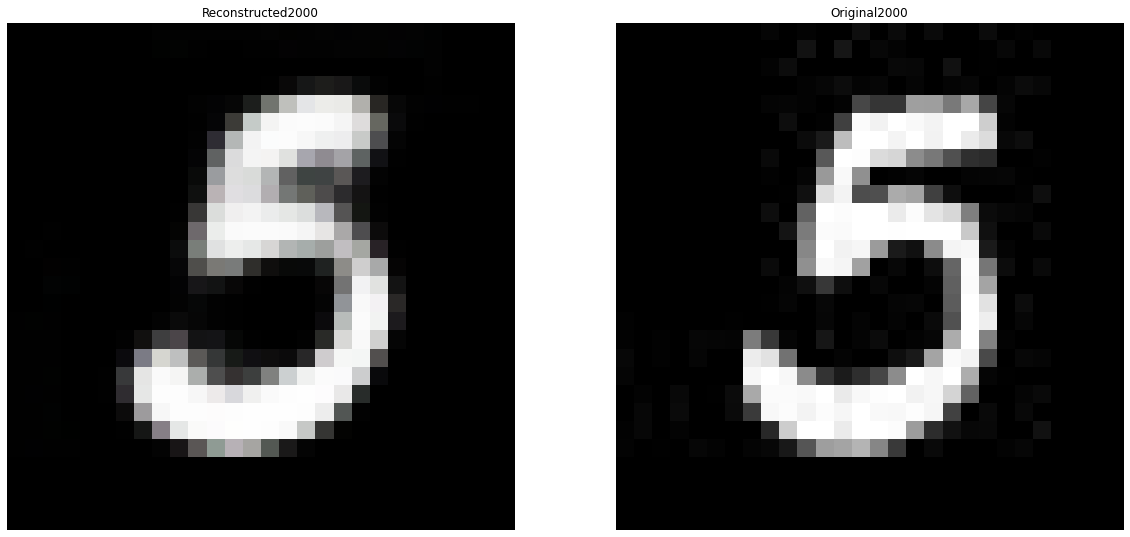

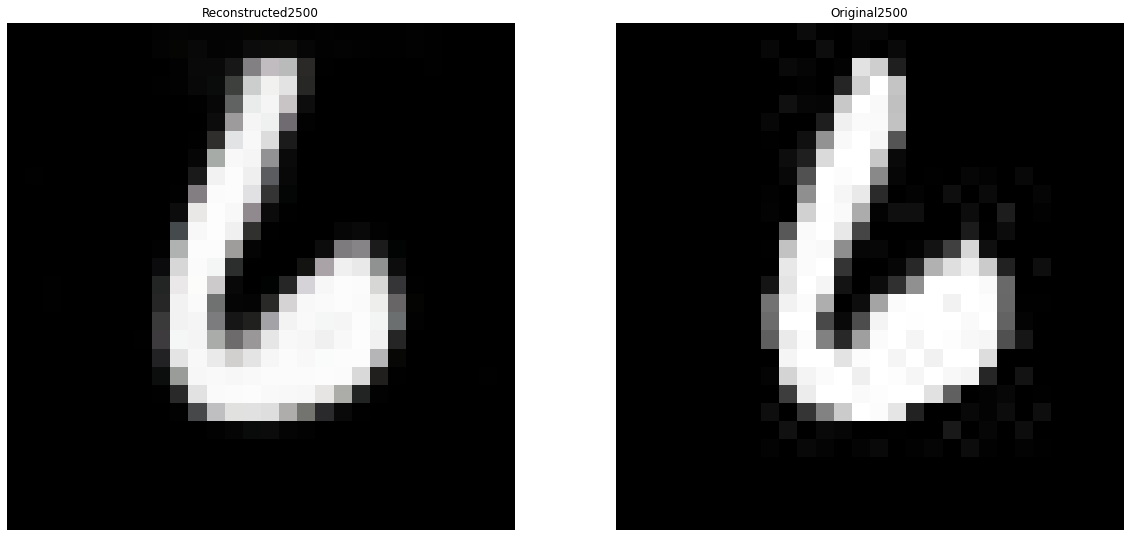

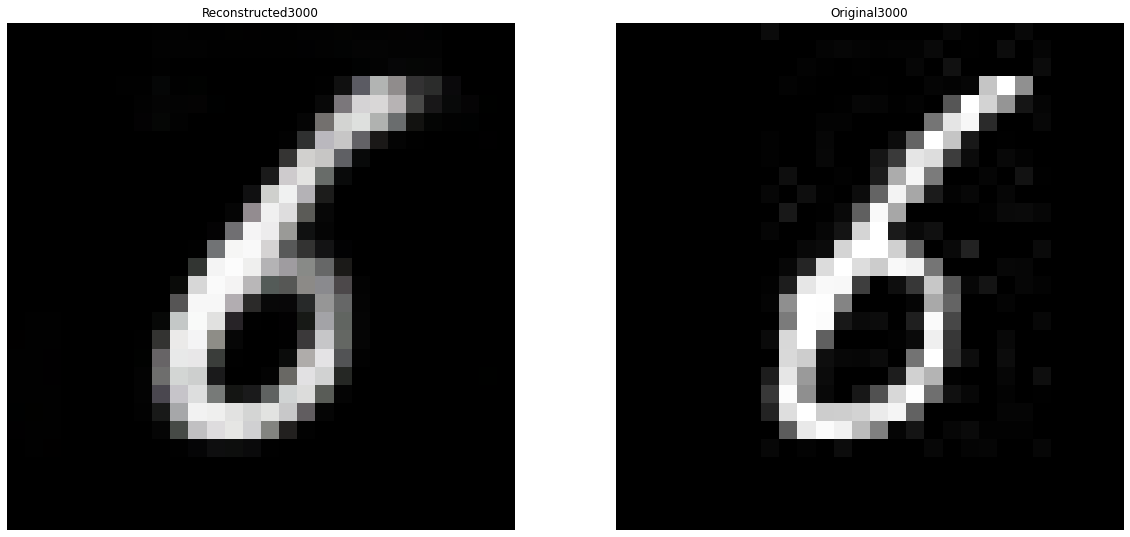

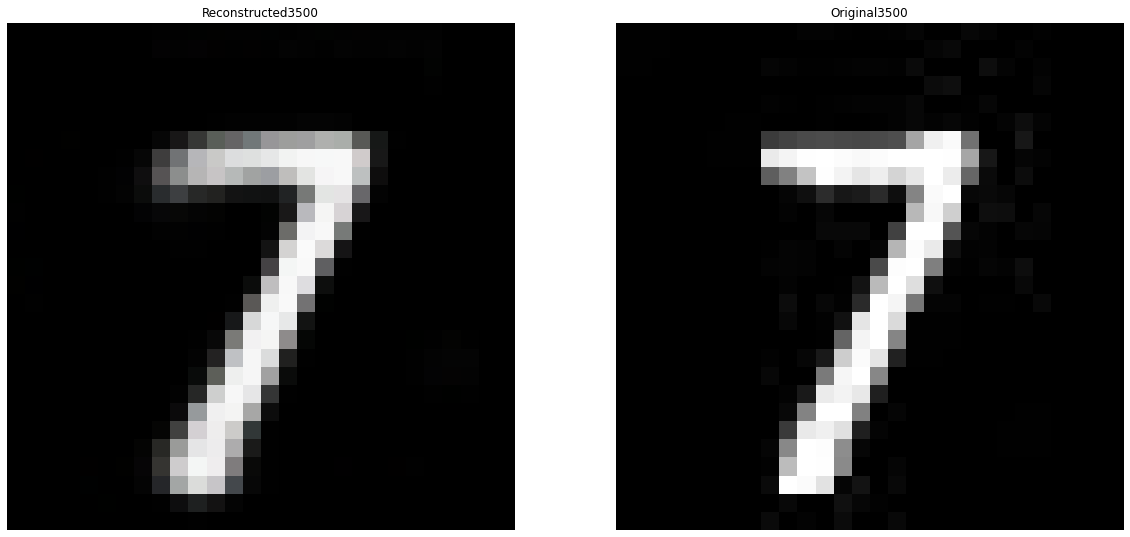

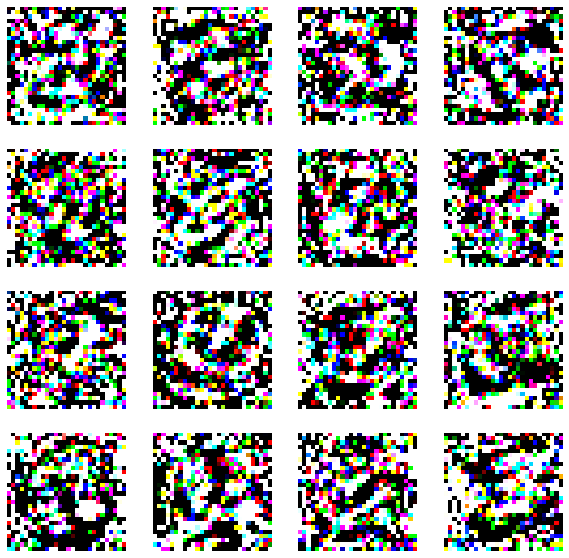

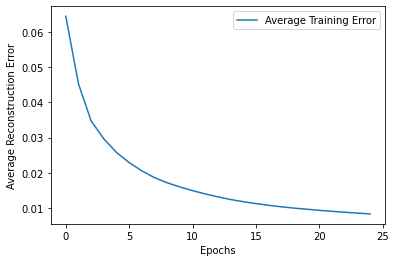

0

In [117]:
threeLayer(128,256,512)

Classification using the compressed representation from the encoder with 3
hidden layer

Epoch 1/40
356/356 [==============================] - 2s 5ms/step - loss: 0.3494 - accuracy: 0.8827 - val_loss: 0.1255 - val_accuracy: 0.9594
Epoch 2/40
356/356 [==============================] - 2s 5ms/step - loss: 0.1027 - accuracy: 0.9669 - val_loss: 0.0856 - val_accuracy: 0.9715
Epoch 3/40
356/356 [==============================] - 2s 5ms/step - loss: 0.0728 - accuracy: 0.9761 - val_loss: 0.0803 - val_accuracy: 0.9763
Epoch 4/40
356/356 [==============================] - 2s 5ms/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.0797 - val_accuracy: 0.9763
Epoch 5/40
356/356 [==============================] - 2s 5ms/step - loss: 0.0315 - accuracy: 0.9903 - val_loss: 0.0663 - val_accuracy: 0.9787
Epoch 6/40
356/356 [==============================] - 2s 5ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0599 - val_accuracy: 0.9821
Epoch 7/40
356/356 [==============================] - 2s 5ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0589 - val_accuracy: 0.9829
Epoch 

0

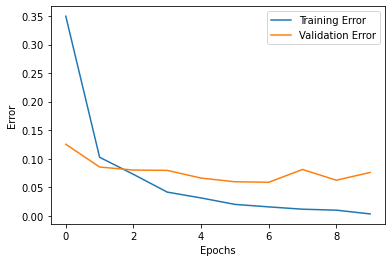

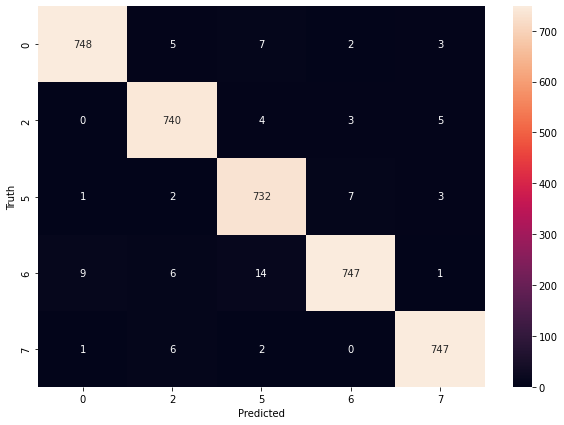

In [130]:
def threeLayer(n1,n2,n3,X_train_flattened = X_train_flattened): #n1 is the the encoding number of neurons for 1-layer-autoencoder

    autoencoder = Sequential([
        Dense(n1, activation = 'sigmoid', input_shape = (28*28*3,)),
        Dense(n2, activation = 'sigmoid'),
        Dense(n3, activation = 'sigmoid'),
        Dense(5, activation = 'sigmoid')])
    
    opt = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt,
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    history = autoencoder.fit(
        X_train_flattened, Y_train,
        shuffle = True,
        epochs = 40,
        verbose = 1,callbacks = [callbacks],validation_data=(X_val_flattened,Y_val))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(['Training Error','Validation Error'], loc='upper right')
    
    what = autoencoder.predict(X_test_flattened)
    y_pred = []
    for i in range(len(what)):
        c = np.argmax(what[i])
        y_pred.append(c)
    
    cm = confusion_matrix(y_pred,test.classes)
    categories = ['0', '2','5','6','7']
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt='d',xticklabels=categories,yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print('Accuracy: %.3f' % accuracy_score(test.classes,y_pred))

    
    return 0
teenLayer(128,256,512,X_train_flattened)

Question 2b

denoising autoencoder with 20% noise and 40% noise for the best one-hidden 
layer autoencoder architecture

In [61]:

def noise(array,factor):
    """
    Adds random noise to each image in the supplied array.

    """
    N = np.zeros((2352))
    for i in range(int(factor*2352)):
        temp = random.randint(0,2352-1)
        N[temp] += np.random.normal(loc=0.5, scale=0.5, size = 1)
    
    trainXNoisy = np.clip(array + N, 0, 1)

    return trainXNoisy

def comparison_plot(img1, img2,index,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(20,50))
    plt.subplot(1,2,1)
    plt.title(f"Reconstructed{index}")
    plt.imshow(img1, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title(f"Original{index}")
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    return 0

X_train_noisy_20 = np.array([noise(i,0.2) for i in X_train_flattened])
X_train_noisy_40 = np.array([noise(i,0.4) for i in X_train_flattened])

(-0.5, 27.5, 27.5, -0.5)

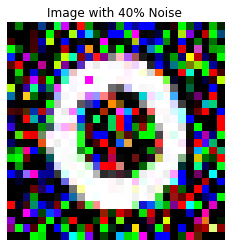

In [134]:
img = X_train_noisy_40[0].reshape(28,28,3)
plt.imshow(img)
#plt.suptitle("Train Image",fontsize=20)
plt.title("Image with 40% Noise ")
plt.axis('off')

Epoch 1/25
356/356 [==============================] - 7s 19ms/step - loss: -0.7493 - cosine_similarity: 0.7493
Epoch 2/25
356/356 [==============================] - 7s 19ms/step - loss: -0.9035 - cosine_similarity: 0.9035
Epoch 3/25
356/356 [==============================] - 7s 19ms/step - loss: -0.9375 - cosine_similarity: 0.9375
Epoch 4/25
356/356 [==============================] - 7s 20ms/step - loss: -0.9526 - cosine_similarity: 0.9526
Epoch 5/25
356/356 [==============================] - 7s 18ms/step - loss: -0.9618 - cosine_similarity: 0.9618
Epoch 6/25
356/356 [==============================] - 6s 18ms/step - loss: -0.9684 - cosine_similarity: 0.9684
Epoch 7/25
356/356 [==============================] - 6s 18ms/step - loss: -0.9732 - cosine_similarity: 0.9732
Epoch 8/25
356/356 [==============================] - 7s 18ms/step - loss: -0.9770 - cosine_similarity: 0.9770
Epoch 9/25
356/356 [==============================] - 7s 19ms/step - loss: -0.9798 - cosine_similarity: 0.9798
E

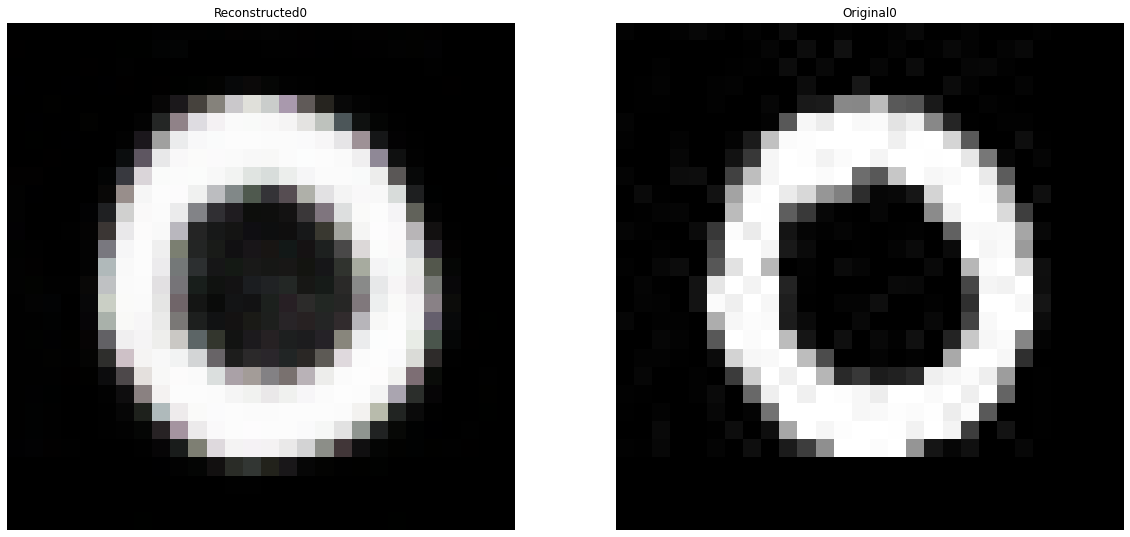

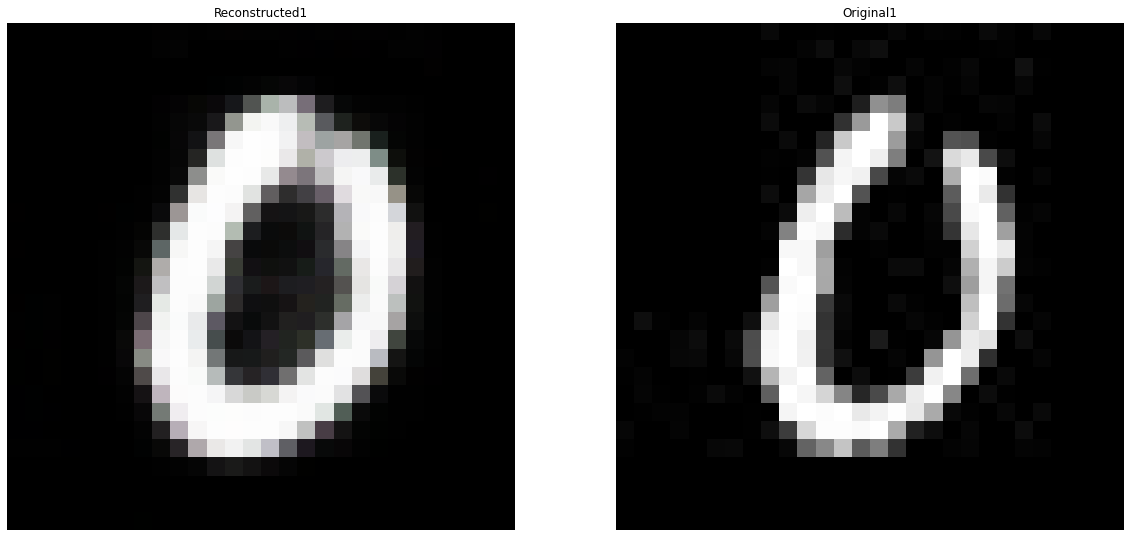

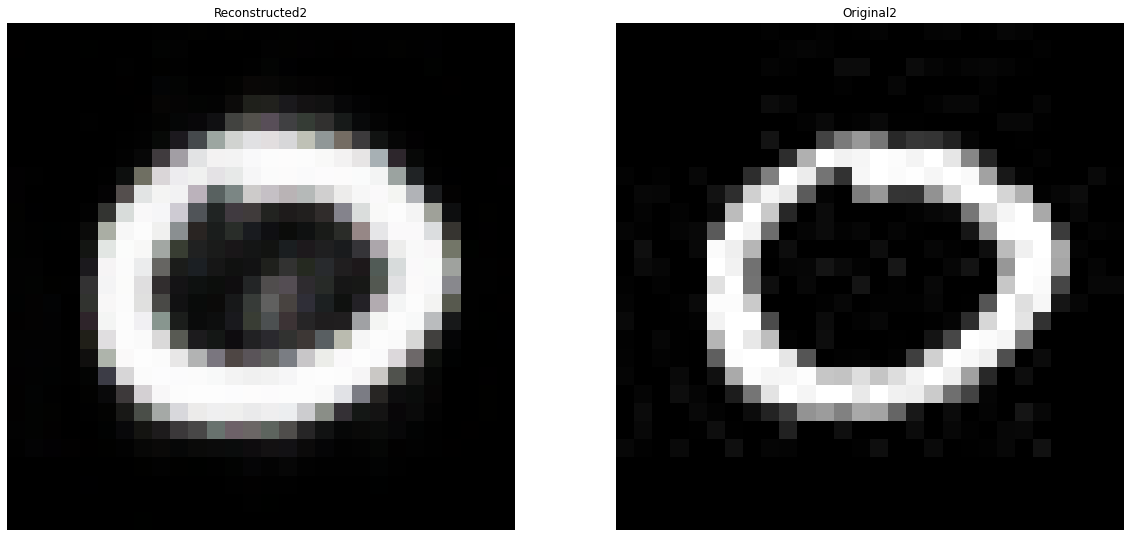

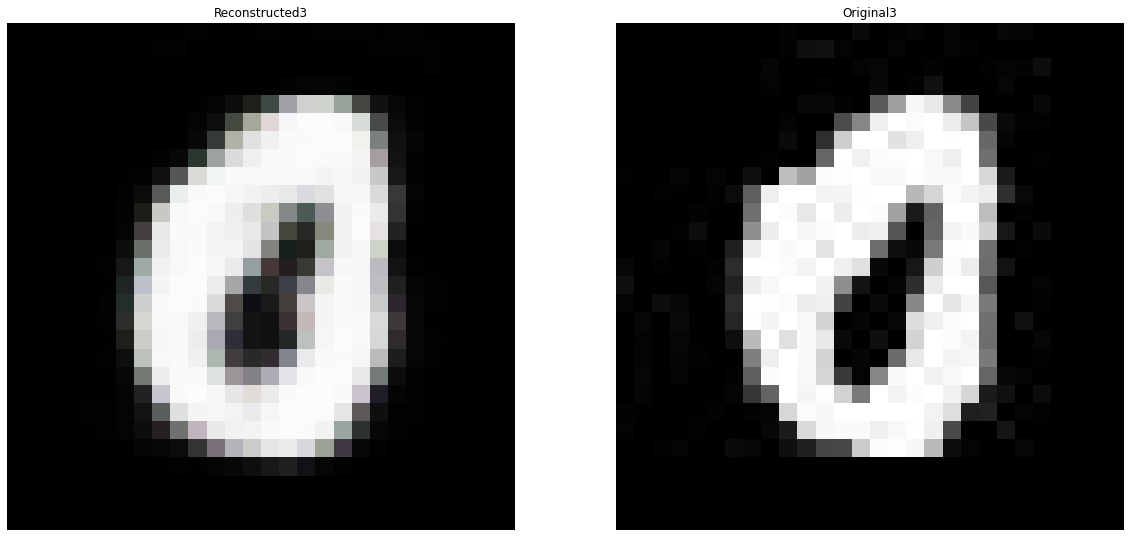

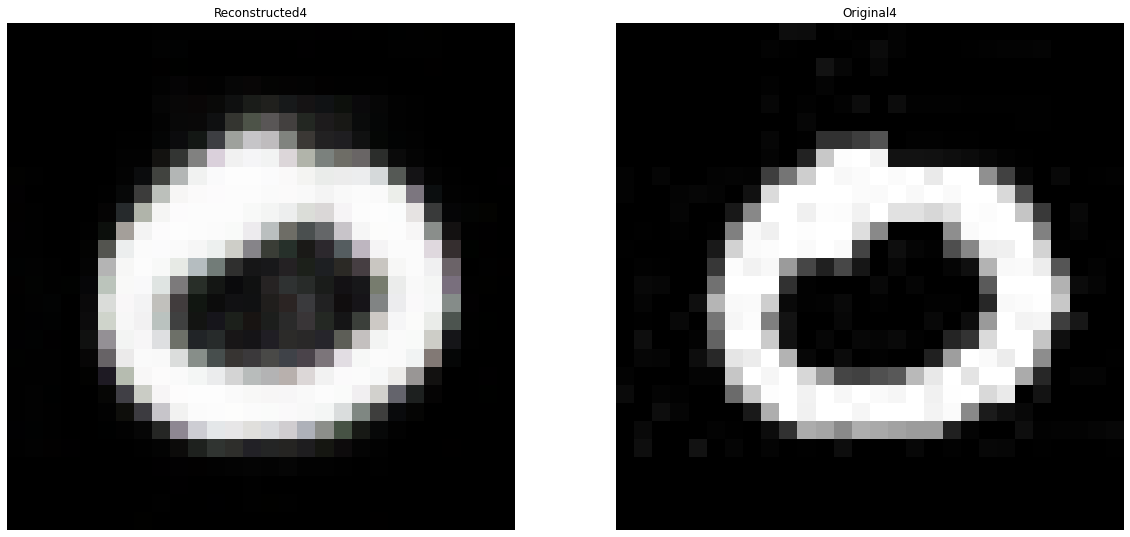

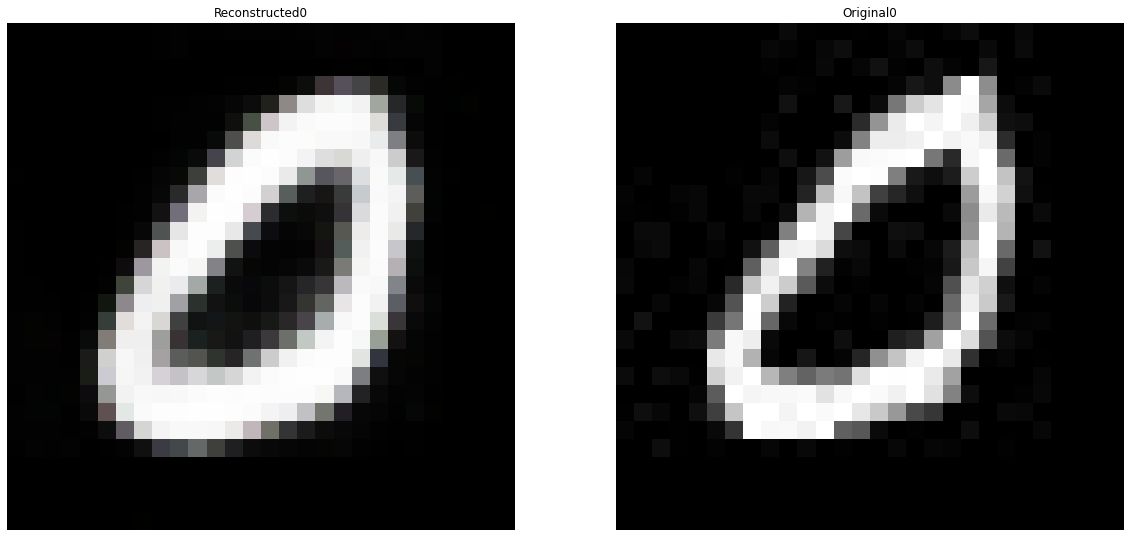

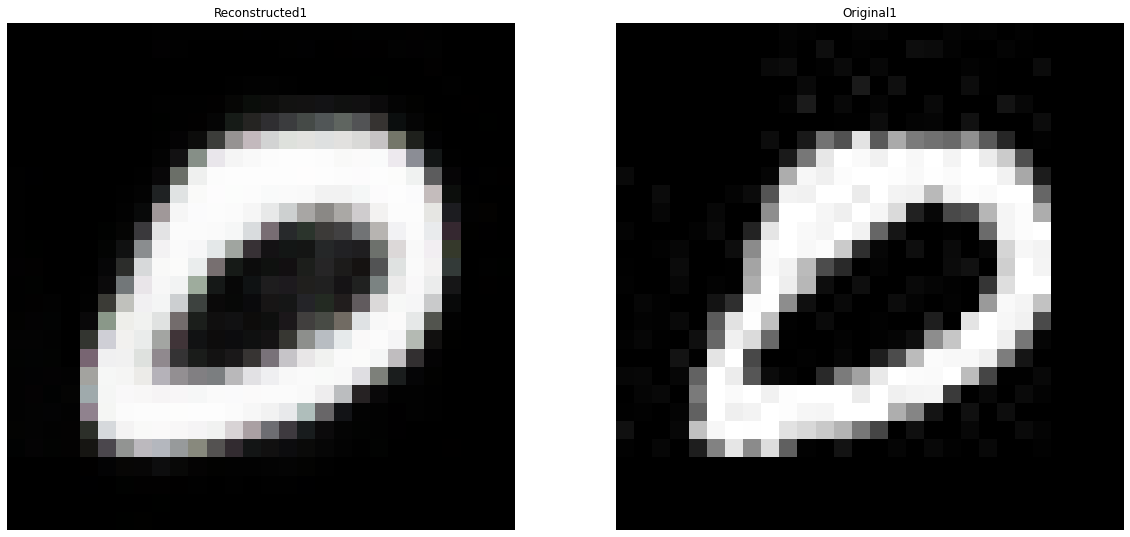

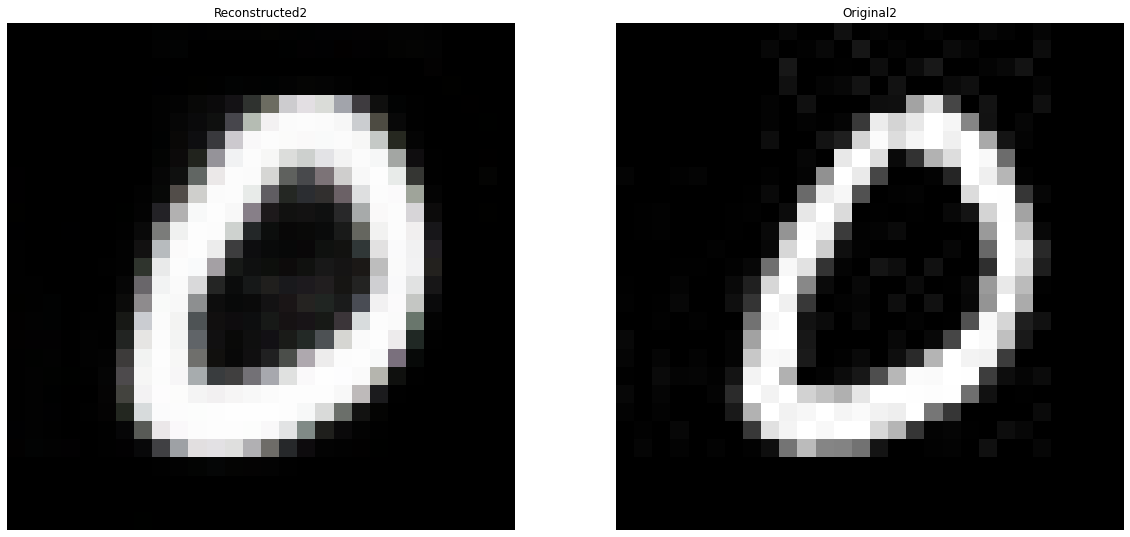

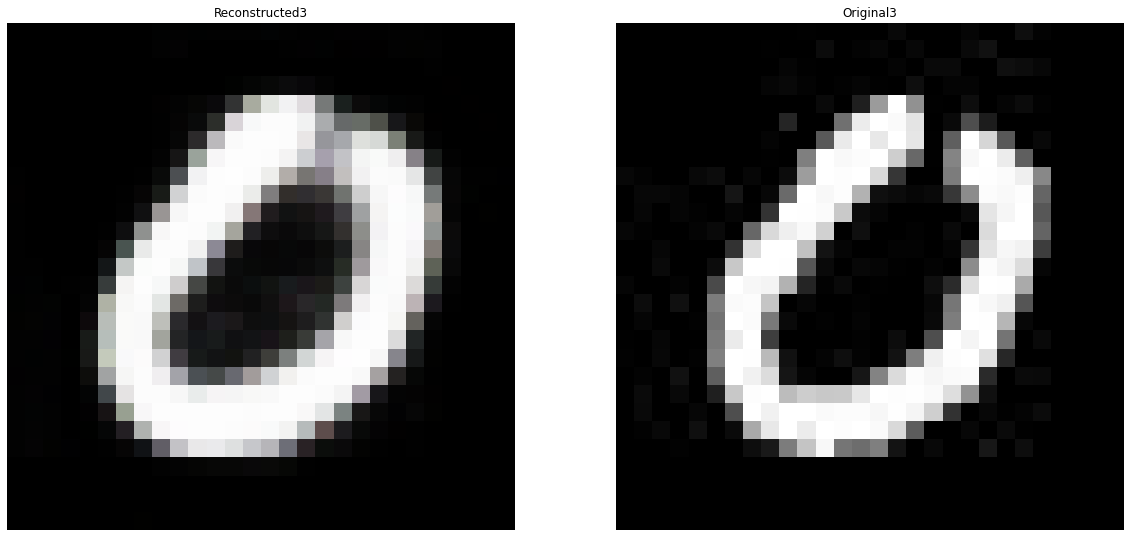

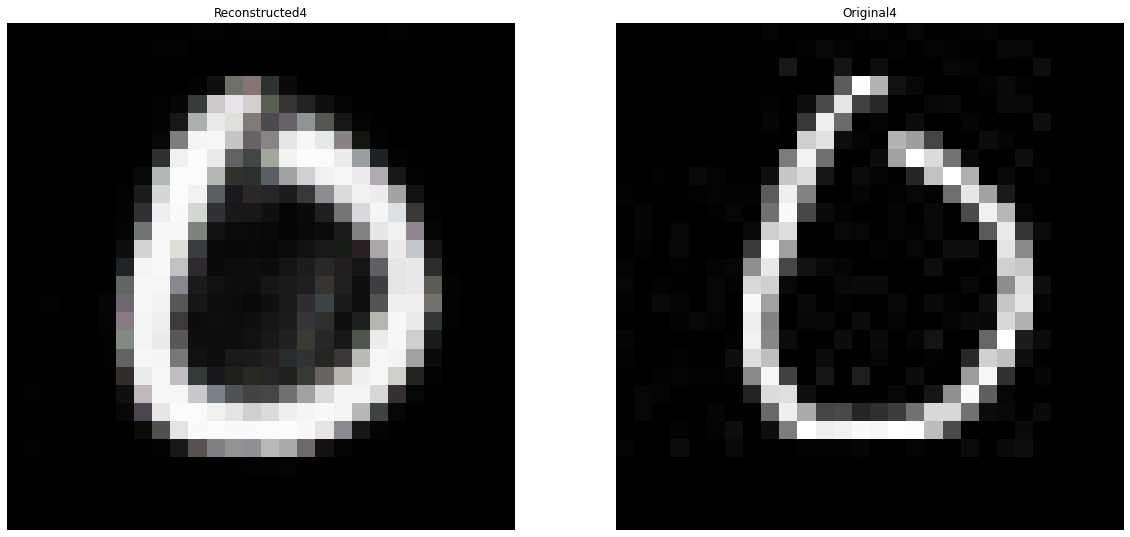

In [119]:
autoencoder = Sequential([
    Dense(512, activation = 'sigmoid', input_shape = (28*28*3,)),
    Dense(28*28*3, activation = 'sigmoid')])

opt = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt,
              loss = CosineSimilarity(), #because images are of large size, they may be far apart in traditional MSE.
              metrics = CS())

history = autoencoder.fit(
    X_train_noisy_40, X_train_flattened,
    shuffle = True,
    epochs = 25,
    verbose = 1,callbacks = [callbacks]
)

what = autoencoder.predict(X_train_flattened)
    
for i in range(0,5):

    this = what[i].reshape((28,28,3))
    comparison_plot(this, X_train_flattened[i].reshape((28,28,3)), index = i)

# this = what[16].reshape((28,28,3))
# comparison_plot(this, X_train[16].reshape((28,28,3)))
#%%
what = autoencoder.predict(X_val_flattened)
for i in range(0,5):

    this = what[i].reshape((28,28,3))
    comparison_plot(this, X_val_flattened[i].reshape((28,28,3)), index = i)
    

Classification accuracy and weight visualization :-

Epoch 1/40
356/356 [==============================] - 4s 9ms/step - loss: 0.2803 - accuracy: 0.9114 - val_loss: 0.1888 - val_accuracy: 0.9407
Epoch 2/40
356/356 [==============================] - 3s 9ms/step - loss: 0.1086 - accuracy: 0.9663 - val_loss: 0.2242 - val_accuracy: 0.9333
Epoch 3/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0515 - accuracy: 0.9863 - val_loss: 0.1998 - val_accuracy: 0.9452
Epoch 4/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0225 - accuracy: 0.9953 - val_loss: 0.2646 - val_accuracy: 0.9349
Epoch 5/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0098 - accuracy: 0.9990 - val_loss: 0.2244 - val_accuracy: 0.9455
Epoch 6/40
356/356 [==============================] - 3s 9ms/step - loss: 0.0043 - accuracy: 0.9999 - val_loss: 0.2679 - val_accuracy: 0.9391
Epoch 7/40
356/356 [==============================] - 3s 10ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2779 - val_accuracy: 0.9389
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0

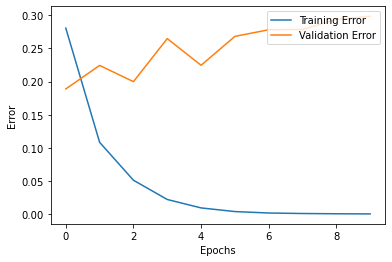

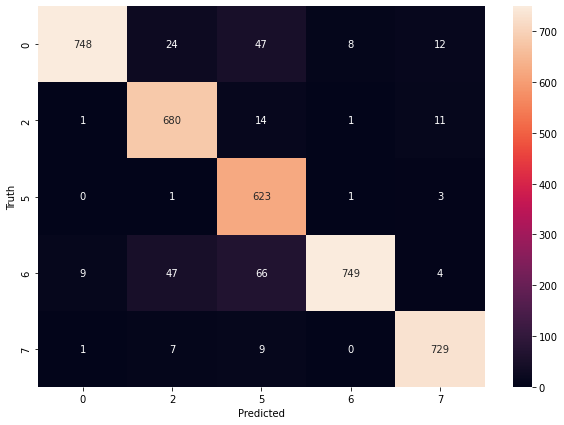

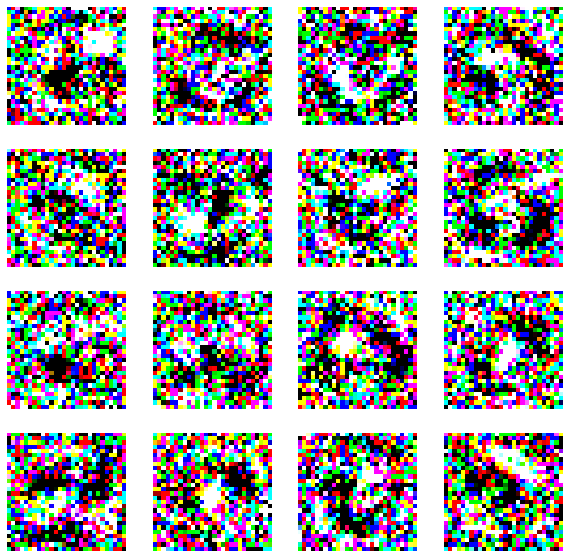

In [138]:
def oneLayer_de(n1,X_train_flattened = X_train_noisy_40): #n1 is the the encoding number of neurons for 1-layer-autoencoder

    autoencoder = Sequential([
        Dense(n1, activation = 'sigmoid', input_shape = (28*28*3,)),
        Dense(5, activation = 'sigmoid')])
    
    opt = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt,
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    history = autoencoder.fit(
        X_train_flattened, Y_train,
        shuffle = True,
        epochs = 40,
        verbose = 1,callbacks = [callbacks],validation_data=(X_val_flattened,Y_val))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(['Training Error','Validation Error'], loc='upper right')
    
    what = autoencoder.predict(X_test_flattened)
    y_pred = []
    for i in range(len(what)):
        c = np.argmax(what[i])
        y_pred.append(c)
    
    
    cm = confusion_matrix(y_pred,test.classes)
    categories = ['0', '2','5','6','7']
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt='d',xticklabels=categories,yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print('Accuracy: %.3f' % accuracy_score(test.classes,y_pred))
    
    fig = plt.figure(figsize=(10,10))  
    maximal_weights =  np.array(autoencoder.weights[0])
    for i in range(512):
        maximal_weights[:,i] = (maximal_weights[:,i]*255)/np.linalg.norm(maximal_weights[:,i])
    for i in range(1,17):
        fig.add_subplot(4, 4, i)
        plt.imshow(maximal_weights[:,i-1].reshape(28,28,3),cmap='gray')
        plt.axis('off')

    
    return 0
oneLayer_de(512,X_train_noisy_40)